In [1]:
%matplotlib widget

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empymod 
from scipy.constants import mu_0
from scipy.constants import epsilon_0
import pygimli as pg

In [3]:
Values = {'Params': ['theta_r', 'theta_s', 'alpha', 'n', 'a', 'b', 'sigma_s', 'sigma_w'],
          'Coarse': [0.025, 0.403, 0.0383, 1.3774, 1.85, 0.0385, 5.89e-4, 0.075],
          'Medium': [0.010, 0.439, 0.0314, 1.1804, 2.10, 0.2450, 8.99e-4, 0.075],
          'Fine'  : [0.010, 0.520, 0.0367, 1.1012, 1.35, -0.090, 4.39e-2, 0.075],
          'Lambot': [0, 0.33, 6.63, 2.57, 1.85, 3.85e-2, 5.89e-4, 0.075]
         }

Models = pd.DataFrame(Values)

Models

,Params,Coarse,Medium,Fine,Lambot
0,theta_r,0.025000,0.010000,0.0100,0.000000
1,theta_s,0.403000,0.439000,0.5200,0.330000
2,alpha,0.038300,0.031400,0.0367,6.630000
3,n,1.377400,1.180400,1.1012,2.570000
4,a,1.850000,2.100000,1.3500,1.850000
5,b,0.038500,0.245000,-0.0900,0.038500
6,sigma_s,0.000589,0.000899,0.0439,0.000589
7,sigma_w,0.075000,0.075000,0.0750,0.075000


In [4]:
# Functions
z =np.linspace(0,2,50, endpoint=False)

def soil_moisture(theta_r, theta_s, z_w, alpha, n, z =z):
    """ Function to define the soil moisture:
    Input:
        theta_r : residual water content [m^3 m ^{-3}]
        theta_s : saturated water content [m^3 m ^{-3}]
        h : pressure head [m]
        alpha : parameter inverse to air entry value [m^{-1}]
        n : parameter inverse of width of pore size distribution
        z_w : water table location (positive pointing down)
        
    Output:
        theta : water retention [m^3 m ^{-3}]
        
    """
    h = z - z_w
    m = 1 - 1/n
    
    theta = []
    
    for hi in h:
        if hi < 0:
            theta.append(theta_r + (theta_s - theta_r) * (1 + np.abs(alpha * hi)**n)**(-m))
        else:
            theta.append(theta_s)
        
    return np.array(theta)
    

def elec_cond_soil_moist(theta, sigma_w, sigma_s, a, b):
    """ Function to calculate electrical conductivity with respect to soil moisture
    Input:
        theta : soil moisture [m^3 m ^{-3}]
        sigma_w : electrical conductivity of soil solution [S/m]
        sigma_r : electrical conductivity of dry soil [S/m]
        a, b : soil parameters
        
    Output:
        sigma : electrical conductivity [S/m]
        
    """
    
    sigma = (a * theta**2 + b * theta) * sigma_w + sigma_s
    
    return sigma

In [16]:
def DualEM_842s(depth, res, coil_orient=np.array(['H', 'P', 'V']), height=0.15):
    """ Here we compute DualEM 842s data using the function `empymod.dipole` function
    for a 1D earth resistivity model
    
    We model the impedance ratio (Z) between the primary (H_p) and secondary (H_s) magnetic fields
    
    The data computed is returned in Quadrature or Out-of-Phase (OP) and In-Phase (IP) components 
    for each coil orientation and coil-coil separation:
    
    H : Horizontal Coplanar -> 2 m, 4 m 8 m coil-coil separation
    V : Vertical Coplanar   -> 2 m, 4 m 8 m coil-coil separation
    P : Perpendicular       -> 2.1 m, 4.1 m 8.1 m coil-coil separation
    Using a Frequency of 9000 Hz
    
    Parameters
    ----------
    depth : ndarray
        Depths of the resistivity model
        
    res : ndarray
        Resistivities of the resistivity model
        
    coil_orient : array of str, e.g.: np.array(['H', 'V', 'P'])
        coil orientations: 'H' for horizontal coplanar, 'V' for vertical coplanar, 'P' for perpendicular
    
    height : float
        height of the device with respect to ground surface [m]
    
    Returns
    -------
    DualEM : ndarray
        DualEM response [OP, IP] for each coil orientation and each coil offset [ppt]
        in parts per thousand
        
        shape: [nr of coil orientations, 2, nr of coil offsets]  
    """
    
    if len(depth) != len(res):
        raise TypeError('depth and res arrays should have the same length!')
    
    # Define DualEM 842s parameters
    
    Freq = 9000
    coil_spacing = [2, 4, 8]
    coil_spacing_p = [2.1, 4.1, 8.2]
    
    res_air = 1e6 # air resistivity
    
    # Define source and receivers geometry
    
    source = [0, 0, -height]
    receivers = [coil_spacing, np.zeros_like(coil_spacing), -height]
    receivers_p = [coil_spacing_p, np.zeros_like(coil_spacing_p), -height]
    
    # Define resistivity model
    res = np.hstack((res_air, res)) # include air resistivity
    
    # Empty array to store store responses
    OUT = []
    
    # Calculate for horizontal coil orientation
    if any(coil_orient == 'H'):
        # Secondary magnetic field
        H_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 66, xdirect = None, 
                              verb=0)*(2j * np.pi * Freq * mu_0) 
        # Primary magnetic field
        H_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime = Freq,
                              ab = 66, verb=0)*(2j * np.pi * Freq * mu_0)   
        op = (H_Hs/H_Hp).imag.amp()# * 1e3 # Out of Phase
        ip = (H_Hs/H_Hp).real.amp()# * 1e3 # In Phase
        OUT.append([op, ip])

    # Calculate for vertical coil orientation
    if any(coil_orient == 'V'):
        # Secondary magnetic field
        V_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 55, xdirect = None, 
                              verb=0)*(2j * np.pi * Freq * mu_0) 
        # Primary magnetic field
        V_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime = Freq, ab = 55, 
                              verb=0)*(2j * np.pi * Freq * mu_0)
        op = (V_Hs/V_Hp).imag.amp()# * 1e3 # Out of Phase
        ip = (V_Hs/V_Hp).real.amp()# * 1e3 # In Phase
        OUT.append([op, ip])

    # Calculate for perpendicular coil orientation
    if any(coil_orient == 'P'):
        P_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 46, xdirect = None, 
                              verb=0)*(2j * np.pi * Freq * mu_0) 
        P_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime= Freq,
                              ab = 66, verb = 0)*(2j * np.pi * Freq * mu_0) 
        op = (P_Hs/P_Hp).imag.amp()# * 1e3 # Out of Phase
        ip = (P_Hs/P_Hp).real.amp()# * 1e3 # In Phase

        OUT.append([op, ip])

    return np.array(OUT).ravel() # [HOP, HIP, VOP, VIP, POP, PIP]

def fop(alpha, n , z_w, theta_r, theta_s, a, b, sigma_w, sigma_s, z):
    
    """ forward operator that transforms soil parameters into
    FDEM measurements """
    
    soil_moist = soil_moisture(theta_r, theta_s, z_w, alpha, n, z)
    sigma = elec_cond_soil_moist(soil_moist, sigma_w, sigma_s, a, b)
    data = DualEM_842s(depth=z, res=1/sigma)
    
    return data 

# Create data for each case

In [257]:
data_coarse = fop(alpha = Models['Coarse'][2],
                  n = Models['Coarse'][3],
                  z_w = 0.7,
                  theta_r = Models['Coarse'][0],
                  theta_s = Models['Coarse'][1],
                  a = Models['Coarse'][4],
                  b = Models['Coarse'][5],
                  sigma_w = Models['Coarse'][7],
                  sigma_s = Models['Coarse'][6],
                  z = z)

model_true_coarse = [Models['Coarse'][2], Models['Coarse'][3], 0.7]

error = 0.001
data_coarse *= np.random.randn(np.size(data_coarse)) * error + 1
relativeError = np.ones_like(data_coarse) * error

In [258]:
class FDEM1D_Vadose_3Param(pg.Modelling):
    """ Forward modelling class
     """
    
    def __init__(self, zvec, theta_r, theta_s, a, b, sigma_w, sigma_s, verbose=False):
        """Initialize with storing values."""
        
        super().__init__(verbose=verbose)
        self.z = zvec
        self.theta_r = theta_r
        self.theta_s = theta_s
        self.a = a
        self.b = b
        self.sigma_w = sigma_w
        self.sigma_s = sigma_s
    
    def response(self, par):
        """ Compute response vector for a certain model [par] 
        """
        
        alpha = par[0]
        n = par[1]
        z_w = par[2]
        theta_r = self.theta_r
        theta_s = self.theta_s
        a = self.a
        b = self.b
        sigma_w = self.sigma_w
        sigma_s = self.sigma_s
        z = self.z

        resp = fop(alpha, n, z_w, theta_r, theta_s, a, b, sigma_w, sigma_s, z)
        return resp
        
    def createStartModel(self, dataVals):
        return pg.Vector([1.,1.,1.])  

In [259]:
# Case Coarse

FOP = FDEM1D_Vadose_3Param(zvec = z,
                           theta_r = Models['Coarse'][0], 
                           theta_s = Models['Coarse'][1],
                           a = Models['Coarse'][4],
                           b = Models['Coarse'][5],
                           sigma_w = Models['Coarse'][7],
                           sigma_s = Models['Coarse'][6]
                          )



lam0 = 0

inv = pg.frameworks.MarquardtInversion(FOP)
inv.modelTrans = pg.trans.TransLogLU(0.01,3)

model_inv_coarse = inv.run(data_coarse, relativeError,  verbose=True, lam=0)
data_inv_coarse = inv.response
print(inv.relrms(), inv.chi2())

29/01/25 - 17:00:43 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=1.000000/1.000000
29/01/25 - 17:00:43 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 38485.1/1.07844e+08
fop: <__main__.FDEM1D_Vadose_3Param object at 0x7f34a2f419e0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7f34a37dc4a0>
Model transformation: <pgcore._pygimli_.RTransLogLU object at 0x7f34a3724950>
min/max (data): 9.3e-06/0.03
min/max (error): 0.1%/0.1%
min/max (start model): 1/1
--------------------------------------------------------------------------------
min/max(dweight) = 38485.1/1.07844e+08
Building constraints matrix
constraint matrix of size(nBounds x nModel) 3 x 3
check Jacobian: wrong dimensions: (0x0) should be (18x3)  force: 1
jacobian size invalid, forced recalc: 1
inv.iter 0 ... chi² =    1.27
--------------------------------------------------------------------------------
inv.iter 1 ... Calculating Jacobian matrix (forced=1)...Create Jacobian matrix (brute force) ... ... 0.0312695 s.
... 0.0412383 s
min data = 9.27261e-06 max data = 0.0259841 (18)
min error = 0.001 max error = 0.001 (18)
min response = 9.27201e-06 max

In [260]:
model_true_coarse

[0.0383, 1.3774, 0.7]

In [261]:
model_inv_coarse

3 [0.0100000001, 2.097096416357143, 2.999999969999998]

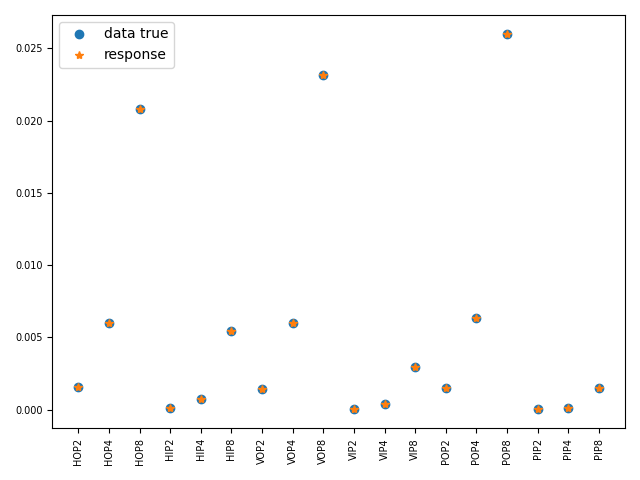

In [262]:
fig, ax = plt.subplots()

data_lab = ['HOP2','HOP4', 'HOP8', 'HIP2', 'HIP4', 'HIP8', 
               'VOP2','VOP4', 'VOP8', 'VIP2', 'VIP4', 'VIP8',
               'POP2','POP4', 'POP8', 'PIP2', 'PIP4', 'PIP8']
ax.plot(data_coarse, 'o', label='data true')
ax.plot(data_inv_coarse, '*', label='response')
ax.set_xticks(range(0, len(data_lab)))
ax.set_xticklabels(data_lab, rotation='vertical')
ax.tick_params(labelsize=7)
ax.legend()
plt.tight_layout()

In [270]:
sm_coarse_true = soil_moisture(theta_r = Models['Coarse'][0],
                               theta_s = Models['Coarse'][1], 
                               z_w = 0.7,
                               alpha = Models['Coarse'][2], 
                               n = Models['Coarse'][3], 
                               z = z)

sm_coarse_inv = soil_moisture(theta_r = Models['Coarse'][0],
                               theta_s = Models['Coarse'][1], 
                               z_w = model_inv_coarse[2],
                               alpha = model_inv_coarse[0], 
                               n = model_inv_coarse[1], 
                               z = z)

sigma_coarse_true = elec_cond_soil_moist(theta = sm_coarse_true,
                                         sigma_w = Models['Coarse'][7],
                                         sigma_s = Models['Coarse'][6],
                                         a = Models['Coarse'][4],
                                         b = Models['Coarse'][5])

sigma_coarse_inv = elec_cond_soil_moist(theta = sm_coarse_inv,
                                         sigma_w = Models['Coarse'][7],
                                         sigma_s = Models['Coarse'][6],
                                         a = Models['Coarse'][4],
                                         b = Models['Coarse'][5])

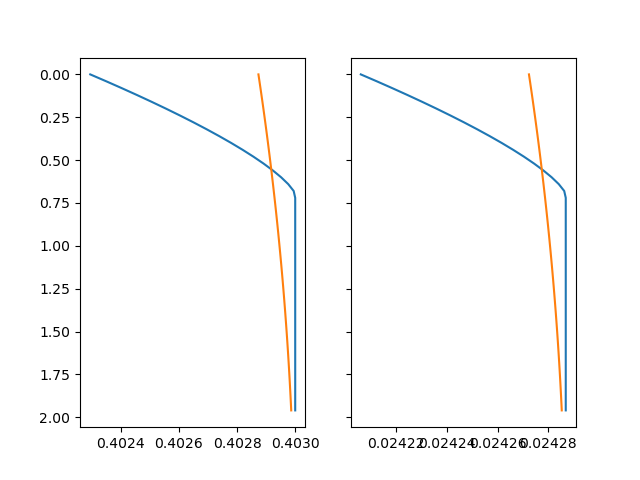

In [272]:
fig, ax = plt.subplots(1,2, sharey=True)

ax[0].plot(sm_coarse_true, z)
ax[0].plot(sm_coarse_inv, z)

ax[1].plot(sigma_coarse_true, z)
ax[1].plot(sigma_coarse_inv, z)

ax[0].invert_yaxis()

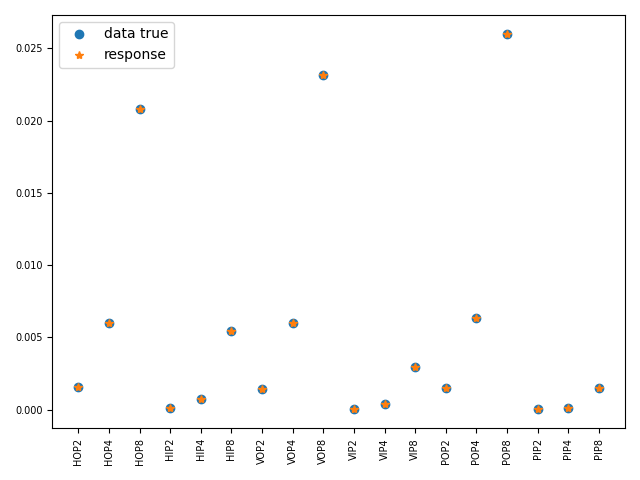

In [273]:
data_coarse_inv = fop(alpha = model_inv_coarse[0],
                      n = model_inv_coarse[1],
                      z_w = model_inv_coarse[2], 
                      theta_r = Models['Coarse'][0],
                      theta_s = Models['Coarse'][1],
                      a = Models['Coarse'][4],
                      b = Models['Coarse'][5],
                      sigma_w = Models['Coarse'][7],
                      sigma_s = Models['Coarse'][6],
                      z = z)

fig, ax = plt.subplots()

ax.plot(data_coarse, 'o', label='data true')
ax.plot(data_coarse_inv, '*', label='response')
ax.set_xticks(range(0, len(data_lab)))
ax.set_xticklabels(data_lab, rotation='vertical')
ax.tick_params(labelsize=7)
ax.legend()
plt.tight_layout()